In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
import joblib

In [2]:
df = pd.read_csv('./data/HCC OP+RFA 20230511 n=2261 去名化.csv')
df.head()
len(df)

2261

In [3]:
df = df.drop(df[df['Treatment'] == 2].index)
df.to_csv('./data/HCC OP 20230511 n=2261 去名化.csv',index=False)
len(df)

c:\Users\Max\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


1480

In [4]:
selected_features = [
    'OP&RFA Data ID','ISD number','20230511 OP_NAP','Milan_out', 'Age', 'Sex', 'Image_Vasulcar_invasion(Portal vein,Hepatic vein)', 'BCLC', 'Child_Class'
    , 'Weight', 'Height', 'BMI', 'WBC', 'HB', 'PLAT', 'PTINR', 'ALB', 'Na', 'K', 'CHOL','BUN', 'CR', 'BILI','ALK-P','LDH'
    , 'ALT', 'AST', 'APRI','FIB4', 'NLR','GLU','GGT', 'AFP', 'HBsAg', 'HCV'
    , 'alcoholism', 'Tumor size', 'Tumor number', 'ALBIscore', 'ALBIgrade'
]

selected_labels = ['Recur', 'Recurrence free survival','Early recur','Early RFS','Late recur','Late RFS']
selected_features_post = ['Histologic grade', 'MVI', 'Inflammation', 'Ishak', 'Steatosis grade']

In [5]:
df = pd.read_csv('./data/HCC OP 20230511 n=2261 去名化.csv')
df_op = df[ selected_features + selected_features_post + selected_labels ]
df_op.to_csv('./data/post_early/HCC OP survival data.csv',index=False)
print(len(df_op))

1480


c:\Users\Max\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


統計每個欄位的缺值
- ISD number 缺 758
- Late recur,Late RFS 缺 652
- 其他都缺不多，最多的為CHOL:147筆,Steatosis grade:153筆

In [6]:
df_op = pd.read_csv('./data/post_early/HCC OP survival data.csv')
nan_counts = df_op.isnull().sum()
result_df = pd.DataFrame({'Column': nan_counts.index, 'NaN_Count': nan_counts.values})
print(result_df)

                                               Column  NaN_Count
0                                      OP&RFA Data ID          0
1                                          ISD number        758
2                                     20230511 OP_NAP        876
3                                           Milan_out          0
4                                                 Age          0
5                                                 Sex          0
6   Image_Vasulcar_invasion(Portal vein,Hepatic vein)          0
7                                                BCLC          0
8                                         Child_Class          0
9                                              Weight         21
10                                             Height         25
11                                                BMI         25
12                                                WBC          0
13                                                 HB          0
14                       

分成三相位齊全跟不齊全的資料集

In [7]:
df = pd.read_csv('./data/post_early/HCC OP survival data.csv')
matched_cases = df[df['20230511 OP_NAP'] == 1]['ISD number']

matched_cases_data = df[df['ISD number'].isin(matched_cases)]
matched_cases_data.to_csv('./data/post_early/HCC OP 20230511 allNAP.csv',index=False)
print(len(matched_cases),len(matched_cases_data))

604 604


c:\Users\Max\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [8]:
for case in matched_cases:
    df = df.drop(df[df['ISD number'] == case].index)
df.to_csv('./data/post_early/HCC OP 20230511 incompleteNAP.csv',index=False)
len(df)

876

統計個案缺值數量
- HCC OP 20230511 allNAP_v1 是刪除了[ 'Late recur','Late RFS','ISD number','20230511 OP_NAP']
- HCC OP 20230511 incompleteNAP_v1 是刪除了[ 'Late recur','Late RFS','ISD number','20230511 OP_NAP']

In [9]:
df_NAP = pd.read_csv('./data/post_early/HCC OP 20230511 allNAP.csv')
df_NAP = df_NAP.drop(columns=[ 'Late recur','Late RFS','ISD number','20230511 OP_NAP'])
num = df_NAP.isna().T.sum()
df_NAP['Eachcase Nan count'] = num
df_NAP.to_csv('./data/post_early/HCC OP 20230511 allNAP_v1.csv',index=False)


c:\Users\Max\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [10]:
column_name = 'Eachcase Nan count'
value_counts = df_NAP[column_name].value_counts()
# 計算總資料數
total_count = value_counts.sum()
# 計算各數值佔總資料的百分比
percentages = value_counts / total_count * 100
# 將數值數量和百分比合併為一個DataFrame
result = pd.concat([value_counts, percentages], axis=1, keys=['Eachcase Nan count', 'Percentage'])
# 輸出結果
print(result)

    Eachcase Nan count  Percentage
0                  417   69.039735
1                  106   17.549669
2                   42    6.953642
3                   20    3.311258
4                   11    1.821192
5                    5    0.827815
6                    2    0.331126
10                   1    0.165563


In [11]:
df = pd.read_csv('./data/post_early/HCC OP 20230511 allNAP_v1.csv')

# 丟掉 num 欄位數值大於 5 的案例
df_filtered = df[df['Eachcase Nan count'] < 6]
print(len(df_filtered))
df_filtered.to_csv('./data/post_early/HCC OP 20230511 allNAP_v1.csv',index=False)

601


c:\Users\Max\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [12]:
df_incomplete = pd.read_csv('./data/post_early/HCC OP 20230511 incompleteNAP.csv')
df_incomplete = df_incomplete.drop(columns=[ 'Late recur','Late RFS','ISD number','20230511 OP_NAP'])
num = df_incomplete.isna().T.sum()
df_incomplete['Eachcase Nan count'] = num
df_incomplete.to_csv('./data/post_early/HCC OP 20230511 incompleteNAP_v1.csv',index=False)

c:\Users\Max\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [13]:
column_name = 'Eachcase Nan count'
value_counts = df_incomplete[column_name].value_counts()
# 計算總資料數
total_count = value_counts.sum()
# 計算各數值佔總資料的百分比
percentages = value_counts / total_count * 100
# 將數值數量和百分比合併為一個DataFrame
result = pd.concat([value_counts, percentages], axis=1, keys=['Eachcase Nan count', 'Percentage'])
# 輸出結果
print(result)

   Eachcase Nan count  Percentage
0                 654   74.657534
1                 125   14.269406
2                  55    6.278539
3                  28    3.196347
4                  11    1.255708
5                   3    0.342466


切資料集

In [14]:
df_NAP = pd.read_csv('./data/post_early/HCC OP 20230511 allNAP_v1.csv')
df_incomplete = pd.read_csv('./data/post_early/HCC OP 20230511 incompleteNAP_v1.csv')

In [15]:
print(len(df_NAP),len(df_incomplete))

601 876


In [16]:
random_num=37
X = df_NAP.drop(columns=['Recur', 'Recurrence free survival','Early recur','Early RFS'])
y_death = df_NAP['Early recur']  # 是否死亡
X_miss = df_incomplete.drop(columns=['Recur', 'Recurrence free survival','Early recur','Early RFS'])
y_death_miss = df_incomplete['Early recur']  # 是否死亡

In [17]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=random_num)
results = sss.split(X, y_death)
train_index, test_index = results.__next__()
results_miss = sss.split(X_miss, y_death_miss)
train_index_miss, test_index_miss = results_miss.__next__()

In [18]:
print(f"Train: {len(train_index)}")
display(df_NAP.iloc[train_index].Recur.value_counts())
print(f"Test: {len(test_index)}")
display(df_NAP.iloc[test_index].Recur.value_counts())
print(f"Train_miss: {len(train_index_miss)}")
display(df_incomplete.iloc[train_index_miss].Recur.value_counts())
print(f"Test_miss: {len(test_index_miss)}")
display(df_incomplete.iloc[test_index_miss].Recur.value_counts())

Train: 420


1    258
0    162
Name: Recur, dtype: int64

Test: 181


1    106
0     75
Name: Recur, dtype: int64

Train_miss: 613


1    320
0    293
Name: Recur, dtype: int64

Test_miss: 263


1    141
0    122
Name: Recur, dtype: int64

In [19]:
train_df = df_NAP.iloc[train_index]
test_df = df_NAP.iloc[test_index]
train_df_miss = df_incomplete.iloc[train_index_miss]
test_df_miss = df_incomplete.iloc[test_index_miss]

In [20]:
train_df = train_df.sample(frac=1, random_state=random_num).sample(frac=1, random_state=random_num).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=random_num).sample(frac=1, random_state=random_num).reset_index(drop=True)
train_df_miss = train_df_miss.sample(frac=1, random_state=random_num).sample(frac=1, random_state=random_num).reset_index(drop=True)
test_df_miss = test_df_miss.sample(frac=1, random_state=random_num).sample(frac=1, random_state=random_num).reset_index(drop=True)

In [21]:
train_df.to_csv("./data/post_early/HCC OP 20230511 allNAP_v1_train.csv", index=False)
test_df.to_csv("./data/post_early/HCC OP 20230511 allNAP_v1_test.csv", index=False)
train_df_miss.to_csv("./data/post_early/HCC OP 20230511 incompleteNAP_v1_train.csv", index=False)
test_df_miss.to_csv("./data/post_early/HCC OP 20230511 incompleteNAP_v1_test.csv", index=False)

c:\Users\Max\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [22]:
print(len(train_df),len(test_df),len(train_df_miss),len(test_df_miss))

420 181 613 263


HCC OP 20230511 train.csv ,HCC OP 20230511 test.csv是包含recur 跟 early recur兩種

In [23]:
combined_train = pd.concat([train_df, train_df_miss], axis=0)
combined_test = pd.concat([test_df, test_df_miss], axis=0)
combined_train.to_csv('./data/post_early/HCC OP 20230511 train.csv',index=False)
combined_test.to_csv('./data/post_early/HCC OP 20230511 test.csv',index=False)
print(len(combined_train),len(combined_test))

1033 444


In [24]:
combined_train = combined_train.drop(columns=['Recur', 'Recurrence free survival'])
combined_test = combined_test.drop(columns=['Recur', 'Recurrence free survival'])
combined_train.to_csv('./data/post_early/HCC OP 20230511 train_early.csv',index=False)
combined_test.to_csv('./data/post_early/HCC OP 20230511 test_early.csv',index=False)

c:\Users\Max\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [25]:
print(len(combined_train),len(combined_test))

1033 444


看資料分布

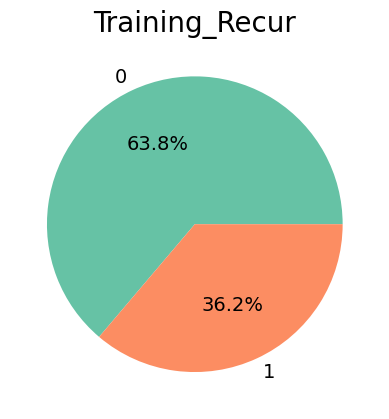

In [26]:
test = pd.read_csv('./data/post_early/HCC OP 20230511 train_early.csv')
# 绘制train['recur']的圆饼图
counts = test['Early recur'].value_counts().to_dict()
counts_keys = list(counts.keys())
counts_keys.sort()
counts = {k: counts[k] for k in counts_keys}
fig, ax = plt.subplots()
colors = sns.color_palette("Set2")[:len(counts.keys())]
ax.set_title('Training_Recur', fontdict={'size': 20})
ax.pie(counts.values(), labels=counts.keys(), colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14})
#plt.savefig('./data_cluster/統計圖表/train分佈.png')
plt.show()

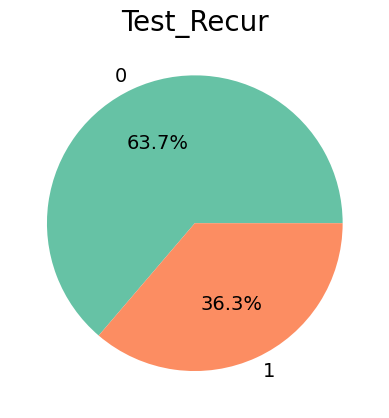

In [27]:
test = pd.read_csv('./data/post_early/HCC OP 20230511 test_early.csv')
# 绘制train['recur']的圆饼图
counts = test['Early recur'].value_counts().to_dict()
counts_keys = list(counts.keys())
counts_keys.sort()
counts = {k: counts[k] for k in counts_keys}
fig, ax = plt.subplots()
colors = sns.color_palette("Set2")[:len(counts.keys())]
ax.set_title('Test_Recur', fontdict={'size': 20})
ax.pie(counts.values(), labels=counts.keys(), colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14})
# plt.savefig('./result/統計圖表/OP_pre test分佈.png')
plt.show()

查看資料集是否有顯著差異

In [28]:
from scipy.stats import ttest_ind
# 計算各欄位的 p-value
p_values = []
for column in combined_train.columns:
    # 執行 t 檢定
    _, p_value = ttest_ind(combined_train[column], combined_test[column])
    p_values.append(p_value)

# 打印 p-value
for column, p_value in zip(combined_train.columns, p_values):
    #print(f"{column}: p-value = {p_value}")
    if p_value < 0.05:
        print(column)

補值

In [29]:
df = pd.read_csv('./data/post_early/HCC OP 20230511 train_early.csv')
df = df.drop(['OP&RFA Data ID','Eachcase Nan count'], axis=1)

# 初始化 KNNImputer 物件
imputer = KNNImputer(n_neighbors=199)

# 執行 KNN 補值
df_imputed = imputer.fit_transform(df)

# 將補值後的結果轉換為 DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

# 將補值後的結果加入原始資料集中
df = df_imputed
df.to_csv('./data/post_early/HCC OP 20230511 train_early_input.csv',index=False)
print(len(df))

1033


In [30]:
train_df = pd.read_csv("./data/post_early/HCC OP 20230511 train_early_input.csv")
test_df = pd.read_csv("./data/post_early/HCC OP 20230511 test_early.csv")
test_df = test_df.drop(['OP&RFA Data ID','Eachcase Nan count'], axis=1)
#先將test資料切分出有缺值跟無缺值
known_data = test_df.dropna()
missing_data = test_df[test_df.isna().any(axis=1)]

# 將空字串替換成 NaN 值
#missing_data.replace(' ', np.nan, inplace=True)
missing_data.head()

,Milan_out,Age,Sex,"Image_Vasulcar_invasion(Portal vein,Hepatic vein)",BCLC,Child_Class,Weight,Height,BMI,WBC,...,Tumor number,ALBIscore,ALBIgrade,Histologic grade,MVI,Inflammation,Ishak,Steatosis grade,Early recur,Early RFS
0,1,73.04,1,1,3,1,45.9,157.8,18.433113,5700,...,1,-2.160,2.0,2.0,1.0,1.0,4.0,0.0,1,17.1
1,1,48.93,1,0,1,1,85.5,170.4,29.446042,8900,...,1,-2.894,1.0,2.5,1.0,1.0,6.0,1.0,0,24.0
3,0,60.00,1,0,0,1,63.5,170.0,21.972318,7900,...,1,-2.956,1.0,2.0,0.0,1.0,2.0,NaN,0,24.0
12,1,50.21,1,0,1,1,72.7,165.9,26.414454,6100,...,1,-2.123,2.0,2.0,0.0,1.0,2.0,NaN,0,24.0
16,0,64.84,1,0,1,1,87.6,167.9,31.074397,5700,...,1,-2.742,1.0,2.0,0.0,1.0,2.0,2.0,0,24.0


In [31]:
k = 199
imputer = KNNImputer(n_neighbors=k)

for i in range(1,len(missing_data)+1):
    nan_df = missing_data.iloc[i-1:i, :]
    #train_df = pd.concat([train_df,nan_df], ignore_index=True)
    train_df = train_df.append(nan_df)
    
    imputed = imputer.fit_transform(train_df)
    # 進行KNN補值
    df_imputed = pd.DataFrame(imputed, columns=train_df.columns)
    # 提取最後一列資料成為新的 Series 物件
    last_row = df_imputed.iloc[-1,:]
    #known_data = pd.concat([known_data,last_row], ignore_index=True)
    known_data = known_data.append(last_row)
    # 刪除 DataFrame 的最後一列資料
    train_df = train_df.drop(train_df.index[-1])
known_data.to_csv("./data/post_early/HCC OP 20230511 test_early_input.csv",index=False)

C:\Users\Max\AppData\Local\Temp\ipykernel_11440\2216344822.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(nan_df)
C:\Users\Max\AppData\Local\Temp\ipykernel_11440\2216344822.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  known_data = known_data.append(last_row)
C:\Users\Max\AppData\Local\Temp\ipykernel_11440\2216344822.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(nan_df)
C:\Users\Max\AppData\Local\Temp\ipykernel_11440\2216344822.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  known_data = known_data.append(last_row)
C:\Users\Max\AppData\Local\Temp\ipykernel_1144

增加衍生特徵

In [32]:
df = pd.read_csv('./data/post_early/HCC OP 20230511 train_early_input.csv')
column = 'PLAT'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 120000, 0, np.where(df[column] < 150000, 1, 2))
column = 'PTINR'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 1.1, 1, 0)
column = 'ALB'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 3.5, 0, np.where(df[column] < 3.8, 1, 2))
column = 'CR'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 1.2, 1, 0)
column = 'BILI'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 1.2, 0, np.where(df[column] < 2, 1, 2))
column = 'ALT'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 40, 0, np.where(df[column] < 80, 1, 2))
column = 'AST'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 40, 0, np.where(df[column] < 80, 1, 2))
column = 'AFP'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 7, 0,
                               np.where(df[column] < 10, 1,
                                        np.where(df[column] < 20, 2,
                                                 np.where(df[column] < 200, 3, 
                                                          np.where(df[column] < 400, 4,5)))))
column = 'Age'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 50, 0,
                               np.where(df[column] < 60, 1,
                                        np.where(df[column] < 65, 2, 3, 
                                                          )))
column = 'BMI'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 23, 0,
                               np.where(df[column] < 25, 1,
                                        np.where(df[column] < 27, 2,
                                                 np.where(df[column] < 27.5, 3, 
                                                          np.where(df[column] < 30, 4,5)))))
column = 'Tumor size'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 2, 0,
                               np.where(df[column] < 3, 1,
                                        np.where(df[column] < 4, 2,
                                                 np.where(df[column] < 5, 3, 
                                                          np.where(df[column] < 10, 4,5)))))
column = 'Tumor number'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 1, 1, 0)
column = 'NLR'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 2.5, 0,
                               np.where(df[column] < 3, 1,
                                        np.where(df[column] < 4, 2,
                                                 np.where(df[column] < 5, 3,4))))
column = 'FIB4'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 3.25, 1, 0)
column = 'Histologic grade'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 2, 0,
                               np.where(df[column] < 2.5, 1,
                                        np.where(df[column] < 3, 2,3
                                                 )))
column = 'Steatosis grade'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 0, 1, 0)

df.to_csv('./data/post_early/HCC OP 20230511 train_early_input_derived features.csv',index=False)

In [33]:
df = pd.read_csv('./data/post_early/HCC OP 20230511 train_early_input_derived features.csv')
columns_to_ln = ['PLAT', 'BUN', 'CR','ALT','AST','AFP','GGT','CHOL','ALK-P', 'LDH','GLU','Histologic grade']

# 對指定欄位進行 ln 轉換並存儲為新欄位
for column in columns_to_ln:
    new_column_name = 'ln' + column
    df[new_column_name] = np.log(df[column])

df.to_csv('./data/post_early/HCC OP 20230511 train_early_input_derived features.csv',index=False)

In [34]:
df = pd.read_csv('./data/post_early/HCC OP 20230511 test_early_input.csv')
column = 'PLAT'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 120000, 0, np.where(df[column] < 150000, 1, 2))
column = 'PTINR'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 1.1, 1, 0)
column = 'ALB'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 3.5, 0, np.where(df[column] < 3.8, 1, 2))
column = 'CR'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 1.2, 1, 0)
column = 'BILI'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 1.2, 0, np.where(df[column] < 2, 1, 2))
column = 'ALT'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 40, 0, np.where(df[column] < 80, 1, 2))
column = 'AST'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 40, 0, np.where(df[column] < 80, 1, 2))
column = 'AFP'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 7, 0,
                               np.where(df[column] < 10, 1,
                                        np.where(df[column] < 20, 2,
                                                 np.where(df[column] < 200, 3, 
                                                          np.where(df[column] < 400, 4,5)))))
column = 'Age'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 50, 0,
                               np.where(df[column] < 60, 1,
                                        np.where(df[column] < 65, 2, 3, 
                                                          )))
column = 'BMI'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 23, 0,
                               np.where(df[column] < 25, 1,
                                        np.where(df[column] < 27, 2,
                                                 np.where(df[column] < 27.5, 3, 
                                                          np.where(df[column] < 30, 4,5)))))
column = 'Tumor size'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 2, 0,
                               np.where(df[column] < 3, 1,
                                        np.where(df[column] < 4, 2,
                                                 np.where(df[column] < 5, 3, 
                                                          np.where(df[column] < 10, 4,5)))))
column = 'Tumor number'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 1, 1, 0)
column = 'NLR'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 2.5, 0,
                               np.where(df[column] < 3, 1,
                                        np.where(df[column] < 4, 2,
                                                 np.where(df[column] < 5, 3,4))))
column = 'FIB4'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 3.25, 1, 0)
column = 'Histologic grade'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 2, 0,
                               np.where(df[column] < 2.5, 1,
                                        np.where(df[column] < 3, 2,3
                                                 )))
column = 'Steatosis grade'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 0, 1, 0)

df.to_csv('./data/post_early/HCC OP 20230511 test_early_input_derived features.csv',index=False)

In [35]:
df = pd.read_csv('./data/post_early/HCC OP 20230511 test_early_input_derived features.csv')
columns_to_ln = ['PLAT', 'BUN', 'CR','ALT','AST','AFP','GGT','CHOL','ALK-P', 'LDH','GLU','Histologic grade']

# 對指定欄位進行 ln 轉換並存儲為新欄位
for column in columns_to_ln:
    new_column_name = 'ln' + column
    df[new_column_name] = np.log(df[column])

df.to_csv('./data/post_early/HCC OP 20230511 test_early_input_derived features.csv',index=False)

In [36]:
train = pd.read_csv('./data/post_early/HCC OP 20230511 train_early_input_derived features.csv')
test = pd.read_csv('./data/post_early/HCC OP 20230511 test_early_input_derived features.csv')
p_values = []
for column in train.columns:
    # 執行 t 檢定
    _, p_value = ttest_ind(train[column], test[column])
    p_values.append(p_value)

# 打印 p-value
for column, p_value in zip(train.columns, p_values):
    #print(f"{column}: p-value = {p_value}")
    if p_value < 0.05:
        print(column)

正規化

In [37]:
raw_df = pd.read_csv('./data/post_early/HCC OP 20230511 train_early_input_derived features.csv')
raw_df_test = pd.read_csv('./data/post_early/HCC OP 20230511 test_early_input_derived features.csv')
display(raw_df.head())

,Milan_out,Age,Sex,"Image_Vasulcar_invasion(Portal vein,Hepatic vein)",BCLC,Child_Class,Weight,Height,BMI,WBC,...,lnCR,lnALT,lnAST,lnAFP,lnGGT,lnCHOL,lnALK-P,lnLDH,lnGLU,lnHistologic grade
0,0.0,72.84,1.0,0.0,1.0,1.0,56.9,168.0,20.160147,4700.0,...,-0.223144,4.343805,4.248495,3.095578,3.663562,4.663439,4.276666,5.164786,5.099866,0.405465
1,0.0,76.96,1.0,0.0,1.0,1.0,58.2,160.6,22.564822,3400.0,...,-0.083382,3.496508,3.465736,1.607436,2.944439,5.087937,4.499810,5.669881,4.695259,0.000000
2,1.0,72.58,1.0,0.0,2.0,1.0,62.7,162.0,23.891175,6200.0,...,0.239017,3.465736,3.891820,2.516082,2.890372,4.927254,4.110874,5.370638,4.488636,1.098612
3,1.0,34.38,2.0,0.0,2.0,1.0,50.7,160.5,19.681486,5300.0,...,-0.385662,3.218876,3.465736,2.570320,3.367296,5.303305,4.430817,5.641907,4.418841,0.916291
4,1.0,57.87,1.0,0.0,1.0,1.0,68.0,165.5,24.826352,6100.0,...,-0.139262,3.526361,3.465736,2.564949,4.077537,5.117994,3.912023,5.231109,4.510860,0.405465


In [38]:
X_train = raw_df.drop(columns=['Early recur','Early RFS'])
y_train = raw_df[['Early recur','Early RFS']]
X_test = raw_df_test.drop(columns=['Early recur','Early RFS'])
y_test = raw_df_test[['Early recur','Early RFS']]

In [39]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
scaled_X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
display(scaled_X_train.tail())
display(y_train.tail())

,Milan_out,Age,Sex,"Image_Vasulcar_invasion(Portal vein,Hepatic vein)",BCLC,Child_Class,Weight,Height,BMI,WBC,...,lnCR,lnALT,lnAST,lnAFP,lnGGT,lnCHOL,lnALK-P,lnLDH,lnGLU,lnHistologic grade
1028,-0.836070,0.339456,1.832662,-0.241664,-0.140541,-0.121387,-0.344536,-0.574696,-0.014418,-1.169705,...,-0.558941,0.409708,-0.315602,-0.911166,-0.458136,-0.448469,-0.015330,-0.237984,2.014054,-0.292994
1029,-0.836070,-0.035722,-0.545654,-0.241664,-1.621956,-0.121387,-0.682452,-0.611841,-0.416643,-0.223306,...,-0.792839,-0.210989,-0.606052,0.940320,-0.874348,1.682219,0.321817,-0.122799,-0.497740,0.625984
1030,1.196072,1.669254,-0.545654,-0.241664,-0.140541,-0.121387,0.894490,0.452966,0.739379,1.243612,...,1.032693,-1.116435,-0.369878,0.074244,-0.625801,1.185794,-0.283477,-0.224937,0.021737,-0.292994
1031,1.196072,0.600413,-0.545654,-0.241664,-0.140541,-0.121387,-1.678870,-0.970903,-1.485803,10.991523,...,-0.015551,-1.035670,-0.425933,-0.874284,0.661718,-1.571117,1.764499,0.346659,-1.597542,2.561613
1032,-0.836070,0.250247,1.832662,-0.241664,-1.621956,-0.121387,0.192664,-1.255677,1.208992,-1.358985,...,-0.596613,-0.567128,-0.369878,-1.297019,0.215432,-0.386614,0.506105,0.388311,1.243244,-0.292994


,Early recur,Early RFS
1028,0.0,24.00
1029,0.0,24.00
1030,0.0,24.00
1031,1.0,8.77
1032,0.0,24.00


In [40]:
scaled_data = pd.concat([scaled_X_train, y_train], axis=1)
scaled_data_test = pd.concat([scaled_X_test, y_test], axis=1)
scaled_data.to_csv('./data/post_early/HCC OP 20230511 train_early_input_derived features_std.csv',index=False)
scaled_data_test.to_csv('./data/post_early/HCC OP 20230511 test_early_input_derived features_std.csv',index=False)
joblib.dump(scaler, './data/post_early/HCC OP 20230511 train_early_input_derived features_scaler.bin')

['./data/post_early/HCC OP 20230511 train_early_input_derived features_scaler.bin']

確認分布

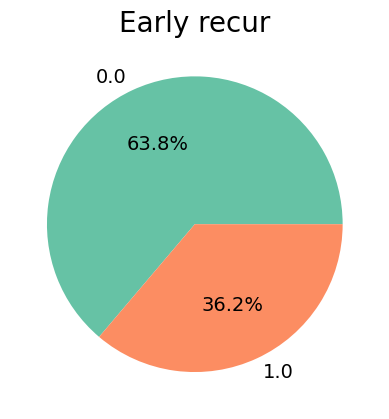

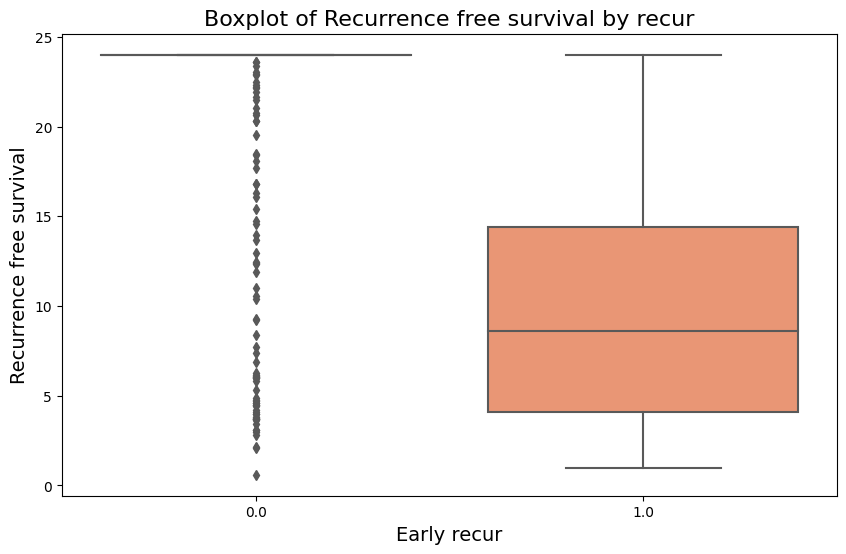

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
test = pd.read_csv('./data/post_early/HCC OP 20230511 train_early_input_derived features_std.csv')
# 绘制train['recur']的圆饼图
counts = test['Early recur'].value_counts().to_dict()
counts_keys = list(counts.keys())
counts_keys.sort()
counts = {k: counts[k] for k in counts_keys}
fig, ax = plt.subplots()
colors = sns.color_palette("Set2")[:len(counts.keys())]
ax.set_title('Early recur', fontdict={'size': 20})
ax.pie(counts.values(), labels=counts.keys(), colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14})
plt.show()

# 绘制train['Early recurrence free survival']和train['Early recur']的箱线图
plt.figure(figsize=(10, 6))  # 设置图形的大小（可选）
sns.boxplot(x=test["Early recur"], y=test["Early RFS"], palette=sns.color_palette("Set2"))
plt.xlabel('Early recur', fontsize=14)  # 设置x轴标签
plt.ylabel('Recurrence free survival', fontsize=14)  # 设置y轴标签
plt.title('Boxplot of Recurrence free survival by recur', fontsize=16)  # 设置图形标题
plt.show()

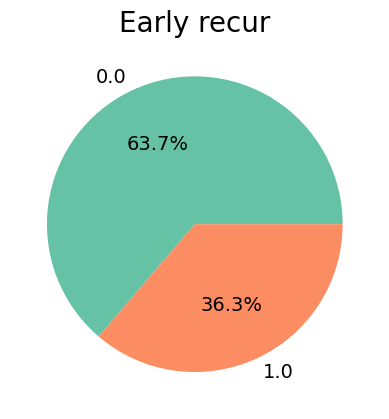

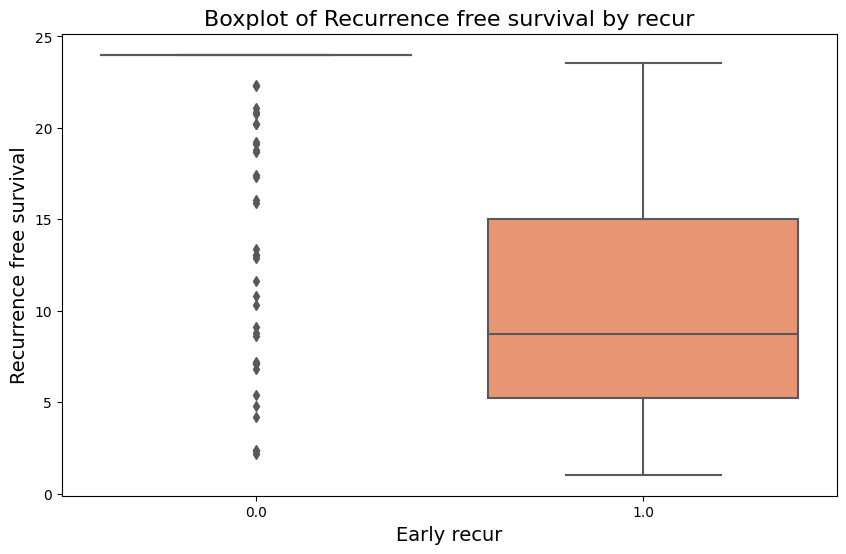

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
test = pd.read_csv('./data/post_early/HCC OP 20230511 test_early_input_derived features_std.csv')
# 绘制train['recur']的圆饼图
counts = test['Early recur'].value_counts().to_dict()
counts_keys = list(counts.keys())
counts_keys.sort()
counts = {k: counts[k] for k in counts_keys}
fig, ax = plt.subplots()
colors = sns.color_palette("Set2")[:len(counts.keys())]
ax.set_title('Early recur', fontdict={'size': 20})
ax.pie(counts.values(), labels=counts.keys(), colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14})
plt.show()

# 绘制train['Early recurrence free survival']和train['Early recur']的箱线图
plt.figure(figsize=(10, 6))  # 设置图形的大小（可选）
sns.boxplot(x=test["Early recur"], y=test["Early RFS"], palette=sns.color_palette("Set2"))
plt.xlabel('Early recur', fontsize=14)  # 设置x轴标签
plt.ylabel('Recurrence free survival', fontsize=14)  # 设置y轴标签
plt.title('Boxplot of Recurrence free survival by recur', fontsize=16)  # 设置图形标题
plt.show()

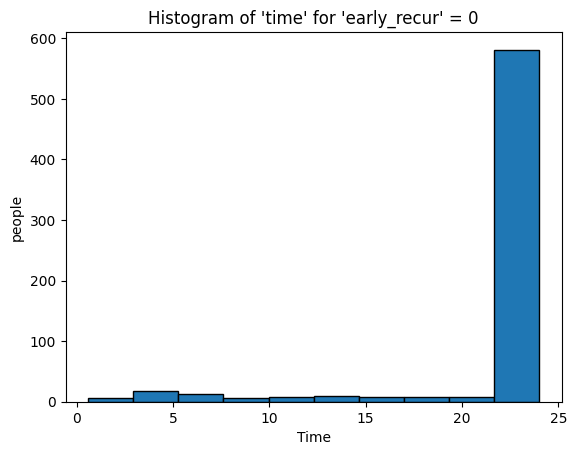

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
test = pd.read_csv('./data/early/HCC OP 20230511 train_early_input_derived features_std.csv')
filtered_data = test[test['Early recur'] == 0]

# 提取 'time' 欄位數值
time_values = filtered_data['Early RFS']

# 繪製直方圖
plt.hist(time_values, bins=10, edgecolor='black')

# 設定圖表標籤和標題
plt.xlabel('Time')
plt.ylabel('people')
plt.title("Histogram of 'time' for 'early_recur' = 0")

# 顯示圖表
plt.show()
